<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch/blob/main/3_Poisson1D_Dirichlet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
 ! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18167 sha256=3f0d22bedfc99308b3925a4eb2d3dcc6e623eddb58f6f34cf13c399f4f89bdce
  Stored in directory: /Users/lucas/Library/Caches/pip/wheels/3f/6c/ae/a1b29aa44759bed46aed9eba5042b7e4038c35a4776f0d24d1
Successfully built pyDOE


In [4]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
# from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


# Tunning Parameters

In [5]:
steps=5000
lr=1e-3
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
# To generate new data:
min=-1
max=1
total_points=500
#Nu: Number of training points (2 as we onlt have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nu=2
Nf=250

# Problem Setup

**Laplace Operator($\Delta$)**

$$\Delta u=u_{xx}+u_{yy} = \frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}$$

**Harmonic Functions**

$$\Delta u =0$$

They are smooth

You need boundary conditions: you need the rate or the value.

You have to solve all points at the same time.

**Poisson equation**

$$\Delta u =f(x)$$

Example: Candle in a room

### Problem

$$-\Delta u=\pi^2sin(\pi x)$$

### Boundary Conditions:

$$u(-1)=0, u(1) =0$$

### Exact solution:

$$u(x)=sin(\pi x)$$

### PDE:
$$-\Delta u=\pi^2sin(\pi x)$$
$$u_{xx}=-\pi^2sin(\pi x)$$
$$\frac{\partial^2u}{\partial x^2}=-\pi^2sin(\pi x)$$

So the residual will be:

$$0=\frac{\partial^2u}{\partial x^2}+\pi^2sin(\pi x)$$

Note: Remeber that our neural network $NN(x)\approx u(x)$ so:

$$\frac{\partial^2NN}{\partial x^2}\approx\frac{\partial^2u}{\partial x^2}$$

$$f=\frac{\partial^2NN}{\partial x^2}+\pi^2sin(\pi x)\rightarrow 0$$


**Initial Conditions (Dirichlet BC)**
$$u(-1)=0$$

$$u(1)=0$$

Set a function to describe our boundary conditions:

$$f_{BC}(x)=1-|x|$$

Note: $f_{BC}$ is not the answer to our PDE, but it helps us describe the boundary condition (Generate data).

## Functions

In [6]:
def f_BC(x):
    return 1-torch.abs(x)
def f_real(x):
    return torch.sin(np.pi*x)
def PDE(x):
    return -1*(np.pi**2)*torch.sin(np.pi*x)


### Neural Network

In [7]:
class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
        loss_BC=self.loss_function(self.forward(x_BC),y_BC)
        return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
        g=x_PDE.clone()
        g.requires_grad=True #Enable differentiation
        f=self.forward(g)
        f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0] #first derivative
        f_xx=autograd.grad(f_x,g,torch.ones([x_PDE.shape[0],1]).to(device), create_graph=True)[0]#second derivative
        return self.loss_function(f_xx,PDE(g))
      
    def loss(self,x_BC,y_BC,x_PDE):
        loss_bc=self.lossBC(x_BC,y_BC)
        loss_pde=self.lossPDE(x_PDE)
        return loss_bc+loss_pde

# Generate data

In [8]:
# get the analytical solution over the full domain
x = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN
y = f_real(x)
print(x.shape, y.shape)

torch.Size([500, 1]) torch.Size([500, 1])


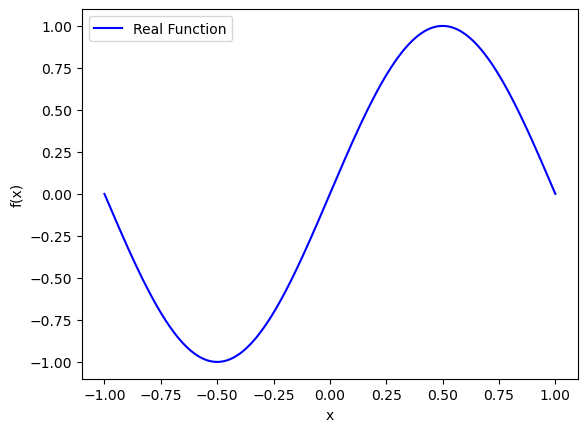

In [10]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real Function')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left');

In [11]:
#def get_training_data(x):
#Nu: Number of training point, # Nf: Number of colloction points
# Set Boundary conditions x=min & x= max
BC_1=x[0,:]
BC_2=x[-1,:]
# Total Tpaining points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC)) 

In [12]:
y_BC=f_BC(x_BC).to(device)

# Train Neural Network

In [13]:
#Store tensors to GPU
torch.manual_seed(123)
x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
#Create Model
model = FCN(layers)
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [14]:
model.lossBC(x_BC,y_BC)

tensor(0.0160, grad_fn=<MseLossBackward0>)

In [15]:
for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_BC,y_BC,x_PDE)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
        print(loss)

tensor(47.8740, grad_fn=<AddBackward0>)
tensor(0.0155, grad_fn=<AddBackward0>)
tensor(0.0031, grad_fn=<AddBackward0>)
tensor(0.0015, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0019, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)


### Plots

In [16]:
# Function
yh=model(x.to(device))
y=f_real(x)
#Error
print(model.lossBC(x.to(device),f_real(x).to(device)))

tensor(6.2449e-07, grad_fn=<MseLossBackward0>)


In [17]:
# Derivative
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

In [18]:
# Detach from GPU
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()

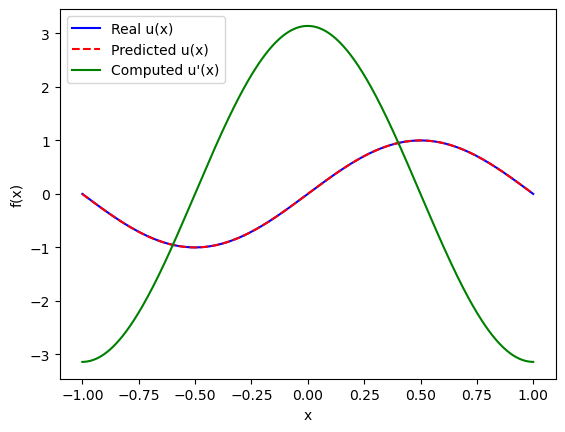

In [21]:
# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real u(x)')
ax1.plot(x,yh_plot,'--r',label='Predicted u(x)')
ax1.plot(x,f_x_plot,color='green',label='Computed u\'(x)')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left');